In [109]:

import pandas as pd
import numpy as np
import rioxarray as rxr
from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint
import geopandas as gpd
import leafmap
import cv2
import matplotlib.pyplot as plt

In [110]:
MIN_MATCH_COUNT = 5

In [111]:
tiff_dir = "data/output/tiff"
src_name = "DJI_20220324154749_0379_T.JPG.tiff"
dst_name = "DJI_20220324154720_0370_T.JPG.tiff"

In [112]:
src_img = rxr.open_rasterio(f"{tiff_dir}/{src_name}").values.squeeze()
dst_img = rxr.open_rasterio(f"{tiff_dir}/{dst_name}").values.squeeze()
#convert temperature floats to 8bit grayscale visualisation
src_img_norm = cv2.normalize(src_img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
dst_img_norm = cv2.normalize(dst_img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

In [113]:
orb = cv2.ORB_create(nfeatures=1000)
src_keypoints, src_descriptors = orb.detectAndCompute(src_img_norm, None)
dst_keypoints, dst_descriptors = orb.detectAndCompute(dst_img_norm, None)

In [114]:
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)
matches = bf.knnMatch(src_descriptors, dst_descriptors,k=2)
all_matches = []
for m, n in matches:
    all_matches.append(m)
print(len(all_matches))

1000


In [115]:
good = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:#Threshold
        good.append(m)
print(len(good))
# Convert keypoints to an argument for findHomography
src_pts = np.float32([ src_keypoints[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst_pts = np.float32([ dst_keypoints[m.trainIdx].pt for m in good]).reshape(-1,1,2)

# Establish a homography
M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)


204


In [116]:
def warpImages(src_img, img1, H):
  src_rows, src_cols = src_img.shape[:2]
  dst_rows, dst_cols = dst_img.shape[:2]

  src_points = np.float32([[0,0], [0,src_rows], [src_cols,src_rows], [src_cols,0]]).reshape(-1,1,2) #coordinates of second image
  src_points = cv2.perspectiveTransform(src_points, H)#calculate the transformation matrix
  dst_points = np.float32([[0,0], [0, dst_rows],[dst_cols, dst_rows], [dst_cols, 0]]).reshape(-1, 1, 2) #coordinates of a reference image

  list_of_points = np.concatenate((src_points, dst_points), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  translation_dist = [-x_min,-y_min]

  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
  out_src_img = cv2.warpPerspective(src_img, H_translation.dot(H), (x_max-x_min, y_max-y_min), borderValue=np.nan)
  src_mask = np.isnan(out_src_img)
  
  out_dst_img = np.empty(out_src_img.shape, np.float32)
  out_dst_img[:] = np.nan
  out_dst_img[translation_dist[1]:dst_rows+translation_dist[1], translation_dist[0]:dst_cols+translation_dist[0]] = img1
  dst_mask = np.isnan(out_dst_img)
  
  mask = src_mask | dst_mask
  out_dst_img[mask] = np.nan
  out_src_img[mask] = np.nan
  
  return out_src_img, out_dst_img

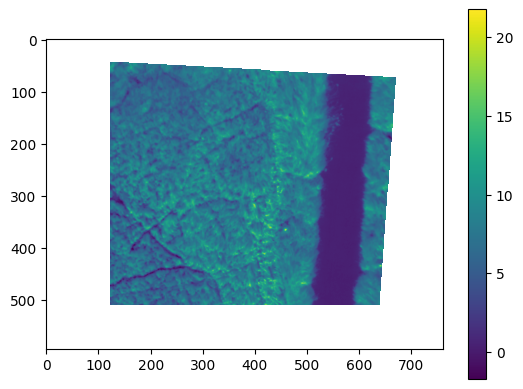

In [142]:
out_src_img, out_dst_img = warpImages(src_img, dst_img, M)
#show img1 and img2
plt.imshow(out_src_img)
plt.colorbar()
plt.show()

In [143]:
#gaussian blur
out_src_img = cv2.GaussianBlur(out_src_img, (5, 5), 0)
out_dst_img = cv2.GaussianBlur(out_dst_img, (5, 5), 0)-0.2

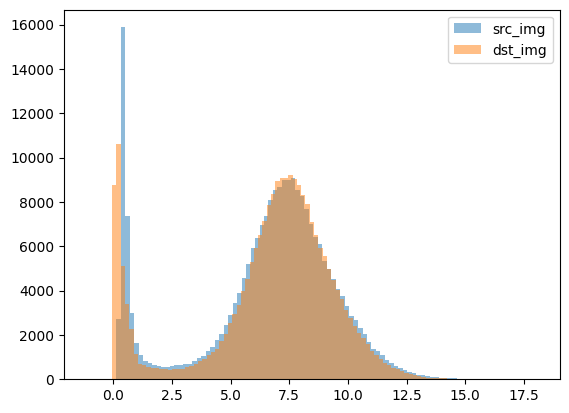

In [144]:
# plot histograms of out_src_img and out_dst_img on the same plot
plt.hist(out_src_img[~np.isnan(out_src_img)], bins=100, alpha=0.5, label='src_img')
plt.hist(out_dst_img[~np.isnan(out_dst_img)], bins=100, alpha=0.5, label='dst_img')
plt.legend(loc='upper right')
plt.show()

In [141]:
np.nanmean(out_dst_img-out_src_img)

0.20114584

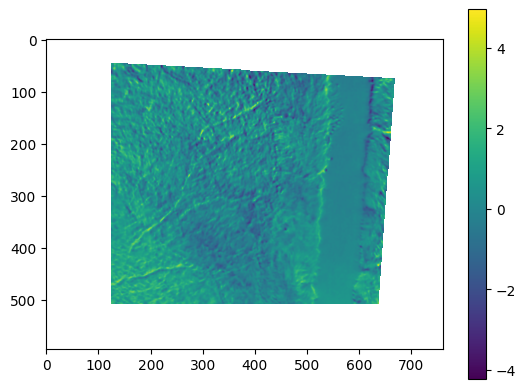

In [136]:
#plot mask
plt.imshow(out_dst_img-out_src_img)
#show colorbar
plt.colorbar()

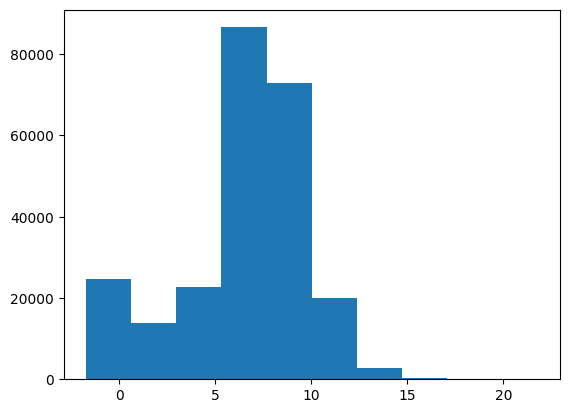

In [119]:
#plot histogram of r_img2
plt.hist(r_img2.ravel())
plt.show()